In [1]:
from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import random_grid, find_optimal_config

from lce import LCEModel, LCEModelItemColdStart
from data_preprocessing import (get_amazon_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)

%matplotlib inline

In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generationa
max_test_workers = 6 # use this manyparallel thread for evaluation each using up to {memory_hard_limit} Gb of RAM

In [3]:
seed = 42

In [4]:
experiment_name = 'lce'

# Experiment setup

In [5]:
data_labels = ['AMZe', 'AMZvg']

In [6]:
init_config = dict(seed = seed,
                   max_iterations = 75,
                   alpha = 0.1,
                   beta = 0.05,
                   max_neighbours=10,
                   )
lce_init_config = dict.fromkeys(data_labels, {'LCE': init_config,  # standard scenario
                                              'LCE(cs)': init_config})  # cold start

In [7]:
params = {
          'regularization': [1, 3, 10, 30],
          'rank': [40] # for initial tuning (exploration)
         }

In [8]:
coeffs = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
    'beta': [0, 0.05, 0.1, 0.3]
}

In [9]:
ranks_grid = [1, 30, 50, 100, 150, 200, 300, 400, 500,
              750, 1000, 1250, 1500, 2000, 2500, 3000]

In [10]:
lce_ranks = {'AMZe': ranks_grid,
             'AMZvg': ranks_grid
            }

In [11]:
topk_values = [1, 3, 10, 20, 30]

In [12]:
target_metric = 'mrr'

In [13]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)

In [14]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Amazon Electronics

In [15]:
lbl = 'AMZe'

In [16]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('/mnt/bulky/datasets/recsys/amazon/ratings_Electronics.csv',
                                                 meta_path='/mnt/bulky/datasets/recsys/amazon/meta/meta_Electronics.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [17]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [18]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Amazon Video Games

In [ ]:
lbl = 'AMZvg'

In [ ]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('/mnt/bulky/datasets/recsys/amazon/ratings_Video_Games.csv',
                                                 meta_path='/mnt/bulky/datasets/recsys/amazon/meta/meta_Video_Games.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_data={'categories': ['Games']}, # filter uniformative category
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [ ]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [ ]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [ ]:
print_data_stats(data_labels, all_data)

AMZe
{'userid': 124895, 'asin': 44843}
density 0.019153791836615672
similarity matrix density 1.1054998336712965
AMZvg
{'userid': 14251, 'asin': 6858}
density 0.13281340440589384
similarity matrix density 9.081814734274188


# Standard experiment

In [ ]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    lce = LCEModel(data_model, item_features=meta_dict[data_label])
    lce.method = 'LCE'
    models = [lce]
    apply_config(models, config, data_label)
    return models

def fine_tune_lce(model, params, label, ntrials=60, record_time_as=None):
    param_grid, param_names = random_grid(params, n=ntrials)
    best_lce_config, lce_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=True,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_lce_config))}
    model_scores = {model.method: lce_scores}
    try:
        if record_time_as:
            save_training_time(f'{experiment_name}_{record_time_as}', model, lce_scores.index, label)
    finally:
        return model_config, model_scores

## tuning

In [ ]:
config = {}
scores = {}
data_models = {}

In [ ]:
lce_init_config['AMZe']['LCE']

{'seed': 42,
 'max_iterations': 75,
 'alpha': 0.1,
 'beta': 0.05,
 'max_neighbours': 10}

### regularization

In [ ]:
_config = {}
_scores = {}
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    model, = prepare_recommender_models(label, data_models, lce_init_config)
    _config[label], _ = fine_tune_lce(model, params, label)
del model

 [############################################################] 0/2 [0<0, 0.00s/it]

           AMZe [#############################################] 0/4 [0<0, 0.00s/it]

In [60]:
_config # will also reuse it in coldstart

{'AMZe': {'LCE': {'regularization': 30, 'rank': 40}},
 'AMZvg': {'LCE': {'regularization': 10, 'rank': 40}}}

### $\alpha, \beta$

In [ ]:
for label in track(data_labels):
    model, = prepare_recommender_models(label, data_models, [lce_init_config, _config])
    config[label], scores[label] = fine_tune_lce(model, coeffs, label, record_time_as='coeff')
    # make sure to save all parameters
    config[label][model.method].update(_config[label][model.method])
del model

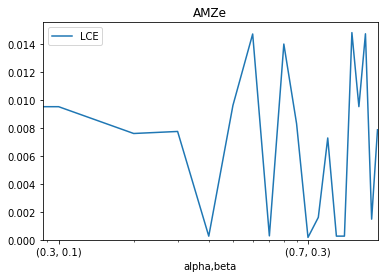

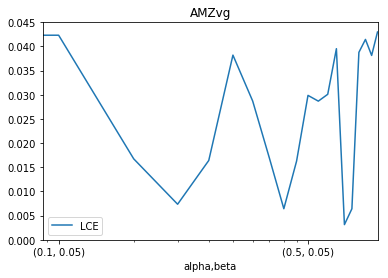

In [61]:
report_results('tuning', scores);

In [62]:
config

{'AMZe': {'LCE': {'alpha': 0.1,
   'beta': 0.0,
   'regularization': 30,
   'rank': 40}},
 'AMZvg': {'LCE': {'alpha': 0.1,
   'beta': 0.3,
   'regularization': 10,
   'rank': 40}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_param', config=config, tuning=scores)

## rank estimation

In [ ]:
rank_config = {}
rank_scores = {}

In [ ]:
for label in track(data_labels):
    model, = prepare_recommender_models(label, data_models,
                                        [lce_init_config, config]) # initiate with optimal config
    rank_config[label], rank_scores[label] = fine_tune_lce(model, {'rank': lce_ranks[label]},
                                                          label, ntrials=0, record_time_as='rank')
del model

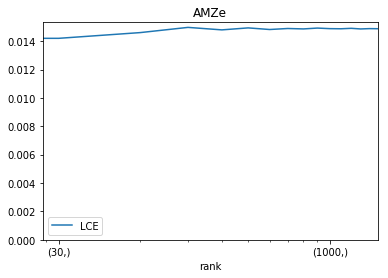

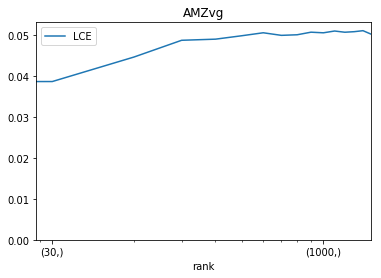

In [63]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores.items() for k, v in scr.items()});

In [64]:
rank_config

{'AMZe': {'LCE': {'rank': 100}}, 'AMZvg': {'LCE': {'rank': 2500}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_rank', config=rank_config, tuning=rank_scores)

## cross-validation

In [ ]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, [lce_init_config, config, rank_config])
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

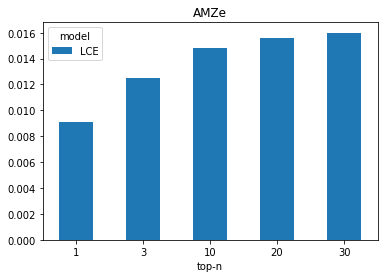

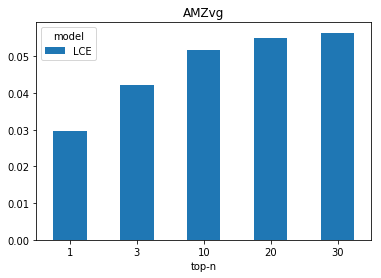

In [65]:
report_results('topn', result, target_metric);

In [66]:
pd.concat({lbl: res.mean(level='top-n').loc[10, :'ranking'] for lbl, res in result.items()}, axis=1)

,,AMZe,AMZvg
type,metric,,
relevance,hr,0.030930,0.116132
ranking,mrr,0.014787,0.051645


### saving data

In [ ]:
save_results(experiment_name, cv=result)

# Cold start

In [ ]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    lce = LCEModelItemColdStart(data_model, item_features=meta_dict[data_label])
    lce.method = 'LCE(cs)'
    models = [lce]
    apply_config(models, config, data_label)
    return models

## tuning

In [ ]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [67]:
lce_init_config['AMZe']['LCE(cs)']

{'seed': 42,
 'max_iterations': 75,
 'alpha': 0.1,
 'beta': 0.05,
 'max_neighbours': 10}

### $\alpha, \beta$

In [ ]:
_config_cold = {}
for label in track(data_labels):
    # reuse regularization param from standard scenario
    _config_cold[label] = {f'{k}(cs)' if k=='LCE' else k: v for k, v in _config[label].items()}
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model, = prepare_cold_start_recommender_models(label, data_models_cold, [lce_init_config, _config_cold])
    config_cold[label], scores_cold[label] = fine_tune_lce(model, coeffs, label, record_time_as=None)
    # make sure to save all parameters
    config_cold[label][model.method].update(_config_cold[label][model.method])
del model

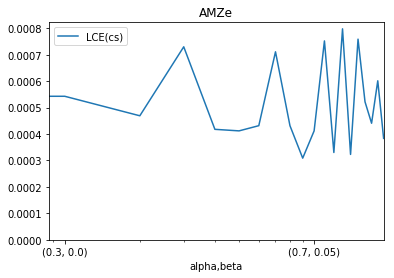

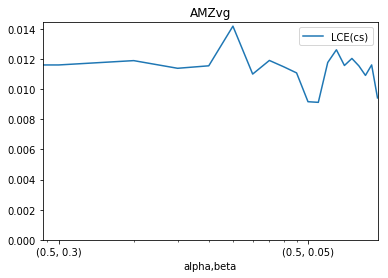

In [68]:
report_results('tuning', scores_cold);

In [69]:
config_cold

{'AMZe': {'LCE(cs)': {'alpha': 0.3,
   'beta': 0.3,
   'regularization': 30,
   'rank': 40}},
 'AMZvg': {'LCE(cs)': {'alpha': 0.3,
   'beta': 0.05,
   'regularization': 10,
   'rank': 40}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart_param', config=config_cold, tuning=scores_cold)

## rank estimation

In [ ]:
rank_config_cold = {}
rank_scores_cold = {}

In [ ]:
for label in track(data_labels):
    model, = prepare_cold_start_recommender_models(label, data_models_cold,
                                                   [lce_init_config, config_cold]) # initiate with optimal config
    rank_config_cold[label], rank_scores_cold[label] = fine_tune_lce(model, {'rank': lce_ranks[label]},
                                                                     label, ntrials=0)
del model

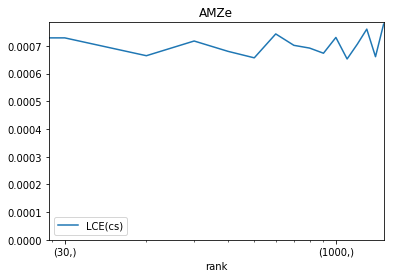

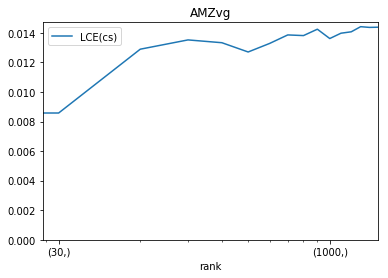

In [70]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores_cold.items() for k, v in scr.items()});

In [71]:
rank_config_cold

{'AMZe': {'LCE(cs)': {'rank': 3000}}, 'AMZvg': {'LCE(cs)': {'rank': 2000}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart_rank', config=rank_config_cold, tuning=rank_scores_cold)

## cross validation

In [ ]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold,
                                                        [lce_init_config, config_cold, rank_config_cold])
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=label))

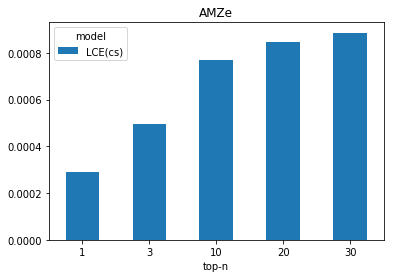

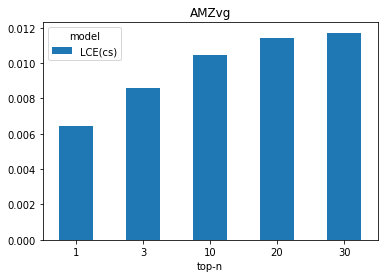

In [72]:
report_results('topn', result_cold, target_metric);

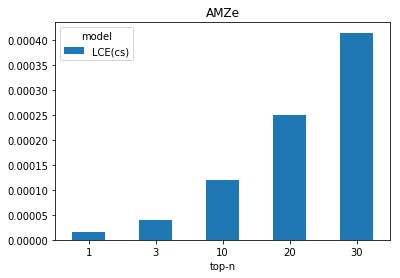

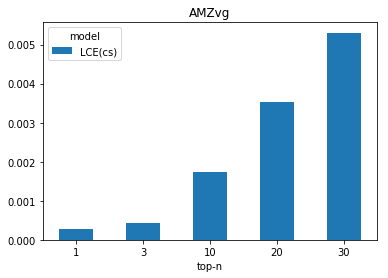

In [73]:
report_results('topn', result_cold, 'coverage');

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart', cv=result_cold)